In [4]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern

In [5]:
x = np.array([-2, 0, 4, 2]).reshape(-1,1)
y = np.array([1, 0.3, -1, 0]).reshape(-1,1)

x_test = np.linspace(-5, 5, 100).reshape(-1,1)

kernel = RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

samples = gp.sample_y(x_test, 3)

#gp.fit(x, y)
#opt_params = gp.get_params()
#print "Opt param", opt_params

#log_lik = gp.log_marginal_likelihood()

# Make the prediction on the meshed x-axis (ask for MSE as well)
#y_pred, sigma = gp.predict(x_test, return_std=True)


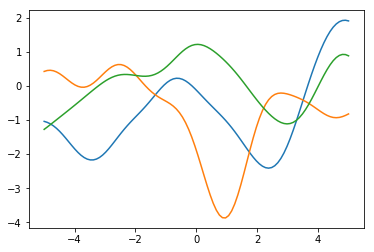

In [6]:
fig = plt.figure();
plt.plot(x_test, samples[:,0]);
plt.plot(x_test, samples[:,1]);
plt.plot(x_test, samples[:,2]);
#plt.fill_between(x_test, y_pred - 2*sigma, y_pred + 2*sigma, color="#dddddd")

Checking if we can estimate the length scale parameters

In [7]:
x2_train = x_test
y2_train = samples[:,0]

kernel2 = RBF(10, (1e-2, 1e2))
print "Parameter before learning", kernel2.theta
gp2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=9, alpha=1e-06)
gp2 = gp2.fit(x2_train, y2_train)
opt_params = gp2.get_params()
print "Parameters after learning", gp2.kernel_.theta
print "Estimated l ", np.exp(gp2.kernel_.theta), "ground truth l ", 1

Parameter before learning [2.30258509]
Parameters after learning [-0.00784631]
Estimated l  [0.99218439] ground truth l  1


Example with multidimensional input

In [9]:
#Dimensions meaning
# 0 - (0/1)
# 1 - (0/1)
# 2 - int (positive: 1,2,3,4)
# 3 - {0,1,2}
# 4 - kappa (0.0 - 1.0)
Xtrain = np.array([
    [0,0,2,0,0.04],  #0
    [1,0,2,0,0.04],  #1
    [1,1,2,0,0.04],  #2
    [1,0,1,0,0.04],  #3
    [0,0,1,0,0.04],  #4
    [0,0,3,0,0.04],  #5
    [1,0,2,2,0.04],  #6
    [1,0,2,0,0.00],  #7
    [1,0,2,0,0.02],  #8
    [1,0,2,0,0.07]   #9
])
Ytrain = np.array([0.357,0.362,0.373,0.346,0.346, #0-4
                   0.340,0.3626,0.3034,0.3562,0.3654]) #5-9


l = np.full(5,10.0)
# se_kernel = RBF(l, (1e-5,1e2))
se_kernel = Matern(l)
#se_kernel = Matern(l, nu=1.2)
print "Parameter before learning", np.exp(se_kernel.theta)


## learning part
gpReg = GaussianProcessRegressor(kernel=se_kernel, n_restarts_optimizer=9, alpha=1e-06)
gpReg = gpReg.fit(Xtrain, Ytrain)
print "Parameters after learning", np.exp(gpReg.kernel_.theta)

Parameter before learning [10. 10. 10. 10. 10.]
Parameters after learning [2.01555931e+02 3.49314646e-04 2.42736374e+01 1.00000000e+05
 5.00278863e-01]


In [10]:
Xtest = np.array([[1,1,2,0,0.01], #10
                  [1,1,2,2, 0.04] #11
                 ])

# expected output [0.358, 0.356]
y_pred, sigma = gpReg.predict(Xtest, return_std=True)
print y_pred

[0.37112171 0.37299963]


### Model estimation
Finding out which kernels to use based on Leave One Out Cross validation.
For that we construct the set of potential kernels to choose from and set of training sets based on the number of training data point we have.
Then for every kernel and for every set we estimate the -log marginal likelihood, which is also a generalization error

In [29]:
# creating kernels set
l = np.full(5,10.0)
kernels = []
kernels.append(RBF(l, (1e-5,1e2)))
kernels.append(Matern(l))
kernels.append(Matern(l, nu=1.5))

from itertools import combinations
N = Xtrain.shape[0]
print "we have ", N, " training points"
indices = range(N)
sets = list(combinations(indices, N-1))
for i in sets:
    print i
    
print Ytrain[[1,2]]

we have  10  training points
(0, 1, 2, 3, 4, 5, 6, 7, 8)
(0, 1, 2, 3, 4, 5, 6, 7, 9)
(0, 1, 2, 3, 4, 5, 6, 8, 9)
(0, 1, 2, 3, 4, 5, 7, 8, 9)
(0, 1, 2, 3, 4, 6, 7, 8, 9)
(0, 1, 2, 3, 5, 6, 7, 8, 9)
(0, 1, 2, 4, 5, 6, 7, 8, 9)
(0, 1, 3, 4, 5, 6, 7, 8, 9)
(0, 2, 3, 4, 5, 6, 7, 8, 9)
(1, 2, 3, 4, 5, 6, 7, 8, 9)
[0.362 0.373]


In [33]:
gen_error = [] # empirical generalization error
for kernel in kernels:
    gen_error_per_kernel = 0 # empirical generalization error for a kernel
    for i,s in enumerate(sets):
        # selecting those training points that are in the set s
        X = Xtrain[s,:]
        Y = Ytrain[[s]]
        ## finding missing point
        missing_idx = sum(range(N)) - sum(s)
        # set Xl - X left out
        Xl = [Xtrain[missing_idx]]
        
        ## fit the gaussian process with a given kernel
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=1e-06)
        gp = gp.fit(X, Y)
        y_pred, sigma = gp.predict(Xl, return_std=True)
        loss = -gp.log_marginal_likelihood()
#         print loss
        gen_error_per_kernel = gen_error_per_kernel + loss
    gen_error.append(gen_error_per_kernel)

# finding the kernel with minimal average generalization error
print gen_error
min_error =  np.min(gen_error)
min_error_kernel = np.argmin(gen_error)
print "Kernel with min error is ", min_error_kernel, " with error ", min_error 

[-128.16075428070954, -172.67711903540638, -195.12250390041032]
Kernel with min error is  2  with error  -195.12250390041032
